This is essentially the same as ls_matrix.ipynb, but we're looking at the ColabFold/PDB comparisons instead of the AlphaFold/ColabFold comparisons

In [471]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [472]:
'''
We need to wrangle our RMSD data a bit before we can make any calculations.
'''

rmsd = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')

# We only need a subset of the columns
rmsd = rmsd[['uniprot', 'pdb', 'cluster', 'complex_rmsd', '2_comp']]

rmsd = rmsd.rename(columns={'complex_rmsd': 'Complex RMSD', '2_comp': 'IMAE'})

rmsd_sub = rmsd[['uniprot', 'cluster']].drop_duplicates()
print(len(rmsd_sub))
rmsd.head()

1536


,uniprot,pdb,cluster,Complex RMSD,IMAE
0,O08967,2r09,U10-005,17.274,33.607
1,O08967,2r09,031,19.503,31.059
2,O08967,2r09,U10-001,16.866,23.513
3,O08967,2r09,U100-004,21.285,52.734
4,O08967,2r09,029,12.546,23.212


In [473]:
two_state = pd.read_csv('./project_pipeline/data/two-state_af_cf.tsv', sep='\t')

two_state_sub = two_state[['uniprot', 'cluster']].drop_duplicates()
print(len(two_state))

1536


In [474]:
lineage = pd.read_csv('./project_pipeline/data/lineage_scores.csv')

lineage_sub = lineage[['uniprot', 'cluster']].drop_duplicates()
print(len(lineage_sub))
lineage.head()

1445


,uniprot,state,conformation,cluster,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8
1,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15
2,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31
3,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33
4,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20


In [475]:
# Also add the cluster conformations
cluster = pd.read_csv('./project_pipeline/data/autoinhibited_cf_interface.tsv', sep='\t')

cluster['cf_conformation'] = cluster['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')

print(cluster['cf_conformation'].value_counts())

cluster = cluster[['uniprot', 'cluster', 'cf_conformation']]

cf_conformation
Closed    1333
Open       203
Name: count, dtype: int64


In [476]:
'''
Now we'll merge the RMSD data with the lineage scores.
'''

# Merge the RMSD and lineage data
merged = pd.merge(rmsd, lineage, on=['uniprot', 'cluster'])

merged_sub = merged.drop_duplicates(subset=['uniprot', 'cluster'])
print(len(merged_sub))

# Merge the cluster data
merged = pd.merge(merged, cluster, on=['uniprot', 'cluster'])

# remove uniformly distributed clusters
merged = merged[~merged['cluster'].str.contains('U')]
merged.head()

1445


,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
7,O08967,2r09,031,19.503,31.059,Autoinhibited,Closed,O08967_031.a3m,UniRef100_A0A024UJ15,157072.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33634, 4762, 4763, 476...",2,30,8,Closed
8,O08967,2r09,031,19.503,31.059,Autoinhibited,Closed,O08967_031.a3m,UniRef100_W4FH40,112090.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33634, 4762, 4763, 476...",2,30,8,Closed
80,O08967,2r09,002,20.558,25.518,Autoinhibited,Closed,O08967_002.a3m,UniRef100_UPI001C3FA3AE,7868.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",11,30,16,Closed
81,O08967,2r09,002,20.558,25.518,Autoinhibited,Closed,O08967_002.a3m,UniRef100_UPI001B7D9AF6,13397.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",11,30,20,Closed
82,O08967,2r09,002,20.558,25.518,Autoinhibited,Closed,O08967_002.a3m,UniRef100_UPI00223D03CD,685728.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",11,30,17,Closed


We want to find the best cluster structure per PDB file.

In [477]:
best = merged.groupby('pdb')['IMAE'].min().reset_index()

merged = pd.merge(best, merged, on=['pdb', 'IMAE'], how='left')

print(len(merged))
print(merged['pdb'].nunique())
merged.head()

13387
275


,pdb,IMAE,uniprot,cluster,Complex RMSD,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_A0A6J2VMB9,29144.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,26,Closed
1,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI00148F4755,1203425.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed
2,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI0014458EF9,310571.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33,Closed
3,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI001BEAA65B,109905.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed
4,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_A0A3Q1H707,80966.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed


In [478]:
merged_sub = merged.drop_duplicates(subset=['uniprot', 'pdb', 'cluster'])

print(merged_sub['cf_conformation'].value_counts())
print(merged_sub['conformation'].value_counts())

cf_conformation
Closed    269
Open        6
Name: count, dtype: int64
conformation
Open      242
Closed     33
Name: count, dtype: int64


In [479]:
# First the variance
var = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('var')

merged['var'] = var

merged = merged.fillna(0)

# Now the mean
mean = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('mean')

merged['mean'] = mean

# Now the max
lmax = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

merged['max'] = lmax

# Min
lmin = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('min')

merged['min'] = lmin

# Need to count the number of unirefs per cluster

counts = merged.groupby(['cluster', 'uniprot']).size().reset_index(name='counts')

print(counts)

# Now we can merge the counts with the lineage scores
lineage_counts = pd.merge(merged, counts, on=['uniprot', 'cluster'])

   cluster uniprot  counts
0      000  O60741       8
1      000  P07038       2
2      000  P28482    1316
3      000  P53042     372
4      000  P60240       4
5      000  Q9Y6K1       5
6      001  P07038       4
7      001  P22681     456
8      001  Q9Y6K1       2
9      005  O08967      14
10     007  P22681      20
11     008  P22681      42
12     010  P62826       4
13     013  Q96BN8     477
14     015  P22681       3
15     016  O08967       4
16     018  P27577     360
17     018  P29350       9
18     018  Q6GQQ9       6
19     019  P22681       9
20     021  P29350      13
21     025  P35520      30
22     026  P28482     897
23     039  P53042      72
24     041  Q8NQJ3       2
25     060  P62826       2
26     061  P12931     210
27     066  P62826     198
28     081  P28482    7392
29     082  P62826       9
30     088  Q8NQJ3       1
31     096  P62826     234
32     099  P28482     890
33     105  P12931      15
34     137  P35520     216
35     139  P28482      70
3

In [480]:
lineage_counts.head()

,pdb,IMAE,uniprot,cluster,Complex RMSD,state,conformation,filename,uniref,taxonId,...,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation,var,mean,max,min,counts
0,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_A0A6J2VMB9,29144.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,26,Closed,3.27688,12.743421,13,0,456
1,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI00148F4755,1203425.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed,3.27688,12.743421,13,0,456
2,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI0014458EF9,310571.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33,Closed,3.27688,12.743421,13,0,456
3,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_UPI001BEAA65B,109905.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed,3.27688,12.743421,13,0,456
4,1fbv,16.614,P22681,001,26.959,Active,Open,P22681_001.a3m,UniRef100_A0A3Q1H707,80966.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,30,Closed,3.27688,12.743421,13,0,456


In [481]:
# Keep only the closed structures.
closed = lineage_counts[lineage_counts['conformation'] == 'Open']

closed_sub = closed.drop_duplicates(subset=['uniprot', 'pdb', 'cluster'])
print(closed_sub['cf_conformation'].value_counts())

cf_conformation
Closed    240
Open        2
Name: count, dtype: int64


In [482]:
pre = closed.drop(columns=['filename', 'uniref', 'taxonId', 'uniprot_lineage', 'cluster_lineage', 'lineage_score', 'cluster_lineage_length', 'state', 'conformation'])
pre = pre.drop_duplicates().reset_index(drop=True)

# What if we got rid of the uniformly sampled clusters? I.e. any cluster with U in it
pre = pre[~pre['cluster'].str.contains('U')]
pre.head()

,pdb,IMAE,uniprot,cluster,Complex RMSD,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
0,1fbv,16.614,P22681,001,26.959,30,Closed,3.276880,12.743421,13,0,456
1,1k5d,13.037,P62826,010,5.794,30,Closed,0.000000,2.000000,2,2,4
2,1k5g,13.059,P62826,066,6.376,30,Closed,0.000000,3.000000,3,3,198
3,1pme,6.000,P28482,081,2.834,30,Closed,23.773057,8.666667,26,0,7392
4,1rrp,10.590,P62826,010,4.928,30,Closed,0.000000,2.000000,2,2,4


In [483]:
#We'll one-hot the state and conformation. 0 if Autoinhibited/Closed, 1 if Active/Open
pre['cf_conformation'] = pre['cf_conformation'].map({'Closed': 0, 'Open': 1})
pre = pre.drop(columns=['uniprot', 'cluster', 'pdb'])
pre.head()

,IMAE,Complex RMSD,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
0,16.614,26.959,30,0,3.276880,12.743421,13,0,456
1,13.037,5.794,30,0,0.000000,2.000000,2,2,4
2,13.059,6.376,30,0,0.000000,3.000000,3,3,198
3,6.000,2.834,30,0,23.773057,8.666667,26,0,7392
4,10.590,4.928,30,0,0.000000,2.000000,2,2,4


In [484]:
# Now we'll make a dataset for the conformation
conf = pre.drop(columns=['Complex RMSD', 'IMAE'])

# Now we'll make a dataset for the Complex RMSD
rmsd = pre.drop(columns=['IMAE', 'cf_conformation'])

# Finally, we'll make a dataset for the IMAE
imae = pre.drop(columns=['Complex RMSD', 'cf_conformation'])

In [485]:
# Split the data into features and target
X = conf.drop('cf_conformation', axis=1)
Y = conf['cf_conformation']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [486]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [487]:
Y_pred = rf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


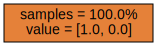

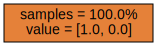

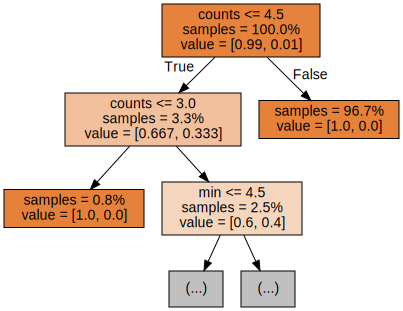

In [488]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [489]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

/home/bjechow/anaconda3/envs/ranforest/lib/python3.12/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc0141fc920>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbffd70c770>})

In [490]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 368}


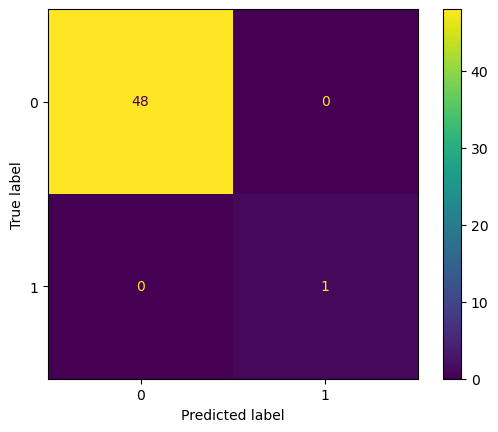

In [491]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [492]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


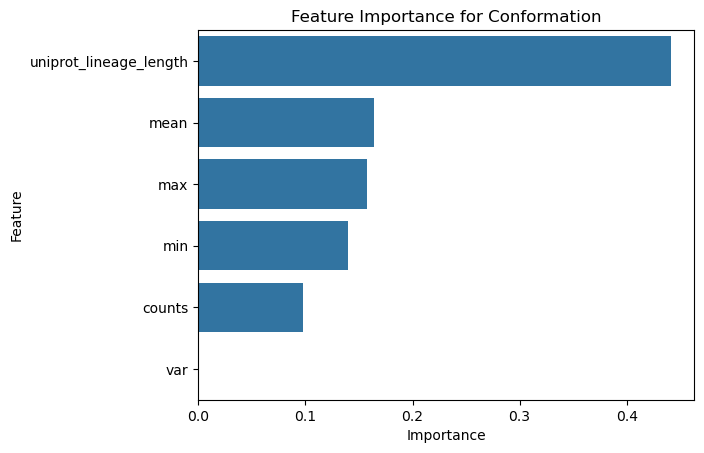

In [493]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importances, y=feature_importances.index)
f.set_title('Feature Importance for Conformation')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_conformation_feature_importance.png')

In [494]:
# Split the data into features and target
Xi = imae.drop('IMAE', axis=1)
Yi = imae['IMAE']

# Split the data into training and test sets
Xi_train, Xi_test, Yi_train, Yi_test = train_test_split(Xi, Yi, test_size=0.2, random_state=42)

In [495]:
rf = RandomForestRegressor()
rf.fit(Xi_train, Yi_train)

RandomForestRegressor()

In [496]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchi = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchi.fit(Xi_train, Yi_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc00f7d1be0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fc00c932d50>})

In [497]:
# Create a variable for the best model
best_rfi = rand_searchi.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchi.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 445}


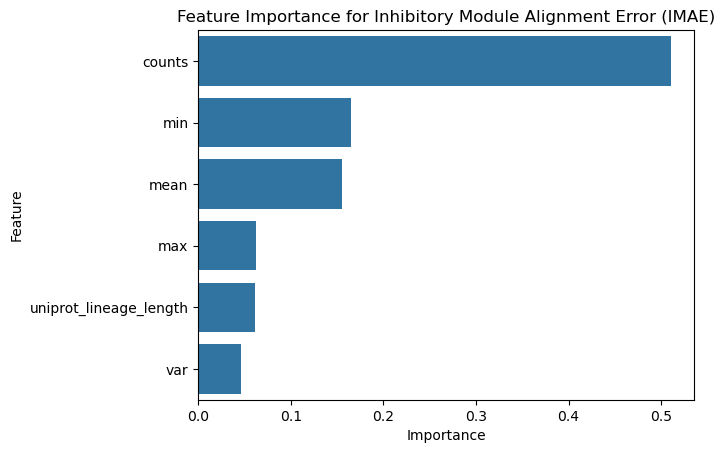

In [498]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesi = pd.Series(best_rfi.feature_importances_, index=Xi_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesi, y=feature_importancesi.index)
f.set_title('Feature Importance for Inhibitory Module Alignment Error (IMAE)')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_imae_feature_importance.png')

In [499]:
# Split the data into features and target
Xc = rmsd.drop('Complex RMSD', axis=1)
Yc = rmsd['Complex RMSD']

# Split the data into training and test sets
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc, test_size=0.2, random_state=42)

In [500]:
rf = RandomForestRegressor()
rf.fit(Xc_train, Yc_train)

RandomForestRegressor()

In [501]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchc = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchc.fit(Xc_train, Yc_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbffd151580>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbffd13d790>})

In [502]:
# Create a variable for the best model
best_rfc = rand_searchc.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchc.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 326}


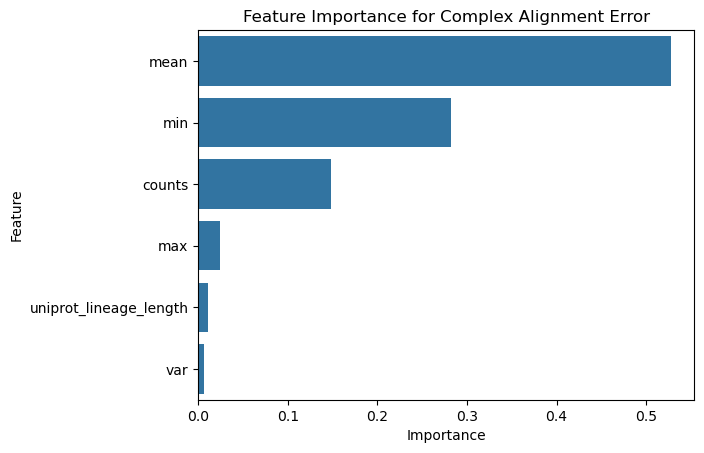

In [503]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesc = pd.Series(best_rfc.feature_importances_, index=Xc_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesc, y=feature_importancesc.index)
f.set_title('Feature Importance for Complex Alignment Error')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_complex_rmsd_feature_importance.png')

242


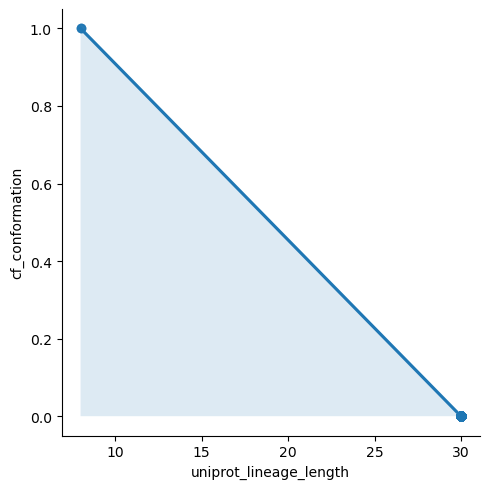

In [504]:
sns.lmplot(pre, x='uniprot_lineage_length', y='cf_conformation')
print(len(pre))

plt.savefig('./project_pipeline/data/figures/closed_cf_pdb_lineage_vs_conf.png')